In [1]:
import pandas as pd
import numpy as np
import seaborn as sbs
import matplotlib.pyplot as plt
import shap
import pickle

In [2]:
np.random.seed(10)

In [3]:
ref = pd.read_pickle("all_pred_compiled.pkl")
df = pd.read_pickle("data.pkl")

In [4]:
off_target = []
target = []
for i in range(len(df)):
    off_target.append(df.loc[i,"off-target seq"])
    target.append(df.loc[i,"target"])

In [5]:
#for chromosome and strand from reference dataframe
chromosome =[]
strand=[]
for i in range(len(ref)):
    for j in range(len(target)):
        if (target[j] == ref.loc[i,"target"]) and (off_target[j] == ref.loc[i,"off-target"]):
            chromosome.append(ref.loc[i,"Chromosome"])
            strand.append(ref.loc[i,"Strand"])
            break

In [6]:
#convert strand into numeric values
for i in range(len(strand)):
    if strand[i] == "+":
        strand[i] = 1
    elif strand[i] == "-":
        strand[i] = 0
    else:
        pass

In [7]:
#to make a 2D array pos_mm to store 1 at places where there is a mismatch in the sequences
pos_mm = []
for i in range(len(df)):
    l=[]
    for j in range(23):
        if (target[i][j]== off_target[i][j] or target[i][j] == 'N' or off_target[i][j] == 'N'):
            l.append(0)
        else:
            l.append(1)
    x = np.transpose(l)#to make a 2D array pos_mm to store 1 at places where there is a mismatch in the sequences
pos_mm = []
for i in range(len(df)):
    l=[]
    for j in range(23):
        if (target[i][j]== off_target[i][j] or target[i][j] == 'N' or off_target[i][j] == 'N'):
            l.append(0)
        else:
            l.append(1)
    x = np.transpose(l)
    pos_mm.append(x)

In [8]:
x = pd.DataFrame(pos_mm, columns = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23'])

In [9]:
#to form lists of transitions, transversions and indels in the Off-target Sequence
count_transversions=[]
count_transitions =[]

for i in range(len(x)):
    a=0
    b=0
    for j in range(23):
        if (target[i][j] == 'A') and ((off_target[i][j] == 'C') or (off_target[i][j] == 'T')):
            a=a+1
        elif (target[i][j] == 'G') and ((off_target[i][j] == 'T') or (off_target[i][j] == 'C')):
            a=a+1
        elif (target[i][j] == 'C') and ((off_target[i][j] == 'G') or (off_target[i][j] == 'A')):
            a=a+1
        elif (target[i][j] == 'T') and ((off_target[i][j] == 'A') or (off_target[i][j] == 'G')):
            a=a+1
        elif (target[i][j] == 'A') and (off_target[i][j] == 'G'):
            b=b+1
        elif (target[i][j] == 'G') and (off_target[i][j] == 'A'):
            b=b+1
        elif (target[i][j] == 'C') and (off_target[i][j] == 'T'):
            b=b+1
        elif (target[i][j] == 'T') and (off_target[i][j] == 'C'):
            b=b+1
        else:
            pass
    count_transversions.append(a)
    count_transitions.append(b)

In [10]:
#to form list of pam_transitions, pam_transversions and pam_indels in last position of off-target Sequence
pam_transversions1=[]
pam_transitions1 =[]

for i in range(len(x)):
    if ((off_target[i][-1]) == 'G'):
        pam_transversions1.append(0)
        pam_transitions1.append(0)
    
    elif (off_target[i][-1] == 'A'):
        pam_transitions1.append(1)
        pam_transversions1.append(0)
    
    elif (off_target[i][-1] =='C') or (off_target[i][-1] == 'T'):
        pam_transversions1.append(1)
        pam_transitions1.append(0)    
    else:
        pass

In [11]:
#to form list of pam_transitions, pam_transversions and pam_indels in 2nd last position of off-target Sequence
pam_transversions2=[]
pam_transitions2 =[]

for i in range(len(x)):
    if ((off_target[i][-2]) == 'G'):
        pam_transversions2.append(0)
        pam_transitions2.append(0)
    
    elif (off_target[i][-2] == 'A'):
        pam_transitions2.append(1)
        pam_transversions2.append(0)
    
    elif (off_target[i][-2] =='C') or (off_target[i][-2] == 'T'):
        pam_transversions2.append(1)
        pam_transitions2.append(0)    
    else:
        pass

In [12]:
pam_transitions = []
pam_transversions = []
pam_indels = []
for i in range(len(x)):
    pam_transitions.append(pam_transitions1[i] + pam_transitions2[i])
    pam_transversions.append(pam_transversions1[i] + pam_transversions2[i])

In [13]:
#to calculate distance in x
distance = []
for i in range(len(x)):
    a = pam_transitions[i]+pam_transversions[i]+count_transitions[i]+count_transversions[i]
    distance.append(a)

In [14]:
max(distance)

14

In [15]:
#to calculate pam_mm in x
pam_mm =[]
for i in range(len(x)):
    a = pam_transitions[i]+pam_transversions[i]
    pam_mm.append(a)

In [16]:
x['Chromosome'] = chromosome
x['Strand'] = strand
x['Count transitions'] = count_transitions
x['Count transversions'] = count_transversions
x['pam transversions'] = pam_transversions
x['pam transitions'] = pam_transitions
x['Distance'] = distance
x['pam mm'] = pam_mm

In [17]:
#to calculate percent of G and C in off-target Sequence
percent_gc = []
for i in range(len(x)):
    a=0
    for j in range(23):
        if (off_target[i][j] == 'G' or off_target[i][j]== 'C'):
            a= a+1
    percent_gc.append((a/len(off_target[i]))*100) 

In [18]:
#to calculate number of G and C from position 11 to 20 in Off-target Sequence
seed_gc = []
for i in range(len(x)):
    a=0
    for j in range(10):
        if (off_target[i][-1-(j+3)] =='G' or off_target[i][-1-(j+3)] == 'C'):
            a=a+1
    seed_gc.append((a/10)*100)

In [19]:
x['% GC'] = percent_gc
x['seed GC'] = seed_gc

In [20]:
x['dG REC3:hybrid'] = df[['dG REC3:hybrid']]
x['dG RNA:DNA'] = df[['dG RNA:DNA']]

In [21]:
y=[]
for i in range(len(x)):
    y.append(0)

In [22]:
y=pd.DataFrame(y, columns=['Output'])

In [23]:
x1=pd.read_excel("D:\\IIT\\PhD projects\\_dG study\\dG for off-t sets\\regression_df.xlsx")
len(x1)

186

In [24]:
x1.head()

,Unnamed: 0,1,2,3,4,5,6,7,8,9,...,pam_mm,pam_transitions,pam_transversions,count_transitions,count_transversions,distance,percent_gc,seed_gc,dG_rec3,dG_DNA
0,0,1,0,0,0,0,1,0,0,0,...,2,2,0,5,0,7,30.434783,50,-134.08,-165.35
1,1,1,0,0,0,0,1,0,0,0,...,2,2,0,5,0,7,30.434783,50,-134.08,-165.35
2,2,0,0,0,0,0,0,0,0,1,...,0,0,0,1,2,3,47.826087,40,-125.18,-146.79
3,3,0,0,0,0,0,0,0,0,1,...,0,0,0,1,2,3,47.826087,40,-125.18,-146.79
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,52.173913,50,-120.50,-177.14


In [25]:
x1.drop("Unnamed: 0", axis=1, inplace=True)
x1.drop("Cell H", axis=1, inplace=True)
x1.drop("Cell K", axis=1, inplace=True)
x1.drop("Cell U", axis=1, inplace=True)
x1.drop("#mm", axis=1, inplace=True)

In [26]:
x1.columns

Index(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13',
       '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
       'Chromosome', 'Strand', 'pam_mm', 'pam_transitions',
       'pam_transversions', 'count_transitions', 'count_transversions',
       'distance', 'percent_gc', 'seed_gc', 'dG_rec3', 'dG_DNA'],
      dtype='object')

In [27]:
x.drop("Count transitions", axis=1, inplace=True)
x.drop("Count transversions", axis=1, inplace=True)
x.drop("pam transitions", axis=1, inplace=True)
x.drop("pam transversions", axis=1, inplace=True)
x.drop("Distance", axis=1, inplace=True)
x.drop("pam mm", axis=1, inplace=True)
x.drop("% GC", axis=1, inplace=True)
x.drop("seed GC", axis=1, inplace=True)
x.drop("dG REC3:hybrid", axis=1, inplace=True)
x.drop("dG RNA:DNA", axis=1, inplace=True)

In [28]:
x['pam_mm'] = pam_mm
x['pam_transitions'] = pam_transitions
x['pam_transversions'] = pam_transversions
x['count_transitions'] = count_transitions
x['count_transversions'] = count_transversions
x['distance'] = distance
x['percent_gc'] = percent_gc
x['seed_gc'] = seed_gc
x['dG_rec3'] = df[['dG REC3:hybrid']]
x['dG_DNA'] = df[['dG RNA:DNA']]

In [29]:
y1=[]
for i in range(len(x1)):
    y1.append(1)

In [30]:
y1=pd.DataFrame(y1, columns=['Output'])

In [31]:
len(y1)

186

In [32]:
X= pd.concat([x,x1], axis=0)

In [33]:
Y=pd.concat([y,y1], axis=0)

In [34]:
X['Output'] = Y

In [35]:
len(Y)

312

In [36]:
X= X.sample(frac=1).reset_index(drop=True)

In [37]:
Y=X["Output"]

In [38]:
X.drop("Output", axis=1, inplace=True)

In [39]:
#for converting X and Y chromosome to integers
for i in range(len(X)):
    if (X.loc[i,"Chromosome"] == 'X'):
        X.loc[i,"Chromosome"] = 23
    elif (X.loc[i,"Chromosome"] == 'Y'):
        X.loc[i,"Chromosome"] = 24
    else:
        pass

In [40]:
x_test = X[0:78]
x_train = X[78:]

In [41]:
y_test= Y[0:78]
y_train = Y[78:]

In [42]:
# training a basic neural network for comparison

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt
import shap

In [44]:
clf = MLPClassifier(hidden_layer_sizes=(256,8), random_state=1, max_iter=600).fit(x_train, y_train)
# clf.predict_proba(x_test)
y_p = clf.predict(x_test)
print(clf.score(x_test, y_test)) #accuracy
cm = metrics.confusion_matrix(y_test, y_p)
print(cm)

0.9230769230769231
[[27  3]
 [ 3 45]]


In [45]:
cv=cross_validate(clf, X, Y, cv=5, return_train_score=True)
print(cv['test_score'])
print(cv['test_score'].mean()) 
print(cv['train_score'])
print(cv['train_score'].mean()) 

[0.875      0.87096774 0.83870968 0.87096774 0.85483871]
0.8620967741935484
[0.93951613 0.968      0.968      0.928      0.9       ]
0.9407032258064516


In [46]:
#confusion matrix, precision-recall curve, accuracy, F1 score

In [47]:
#building a random forest classifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
accuracy=[]
I=[]
J=[]
for i in range(40):
    for j in range(40):
        clf = RandomForestClassifier(n_estimators = i+1, random_state=j)
        clf.fit(x_train,y_train)
        y_p = clf.predict(x_test)
        accuracy.append(metrics.accuracy_score(y_test, y_p))
        I.append(i)
        J.append(j)

In [48]:
print(accuracy)

[0.8205128205128205, 0.8076923076923077, 0.8589743589743589, 0.8076923076923077, 0.8333333333333334, 0.782051282051282, 0.7692307692307693, 0.8461538461538461, 0.8205128205128205, 0.7051282051282052, 0.8589743589743589, 0.8461538461538461, 0.8974358974358975, 0.8461538461538461, 0.8205128205128205, 0.8461538461538461, 0.8974358974358975, 0.8076923076923077, 0.7051282051282052, 0.8461538461538461, 0.8717948717948718, 0.8333333333333334, 0.7692307692307693, 0.8717948717948718, 0.8717948717948718, 0.8846153846153846, 0.7692307692307693, 0.7692307692307693, 0.782051282051282, 0.717948717948718, 0.7435897435897436, 0.7435897435897436, 0.8076923076923077, 0.8205128205128205, 0.7435897435897436, 0.8461538461538461, 0.8717948717948718, 0.8461538461538461, 0.7948717948717948, 0.8461538461538461, 0.8205128205128205, 0.7948717948717948, 0.8974358974358975, 0.8846153846153846, 0.8589743589743589, 0.8589743589743589, 0.8461538461538461, 0.8717948717948718, 0.8589743589743589, 0.782051282051282, 0.8

In [49]:
#third highest
print(accuracy.index(0.9102564102564102))
print(I[123])
print(J[123])

63
3
3


In [50]:
print(max(accuracy))
print(accuracy.index(max(accuracy))) 
print(I[143]) 
print(J[143]) 

0.9487179487179487
143
3
23


In [51]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [52]:
clf = RandomForestClassifier(n_estimators = 4, random_state=23) 
clf.fit(x_train,y_train)
y_p = clf.predict(x_test)
#for cross validation

from sklearn.model_selection import cross_validate
cv=cross_validate(clf, X, Y, cv=5, return_train_score=True)
print(cv['test_score'])
print(cv['test_score'].mean()) 
print(cv['train_score'])
print(cv['train_score'].mean()) 

[0.890625   0.85483871 0.83870968 0.87096774 0.85483871]
0.8619959677419355
[0.95564516 0.98       0.984      0.972      0.968     ]
0.9719290322580644


In [53]:
#logistic regression
#from sklearn.linear_model import LogisticRegression
#I1=[]
#accuracy1 = []
#for i in range(30):
 #   x_train, x_test, y_train, y_test= train_test_split(X,Y, test_size=0.20, random_state=i)
 #   logreg = LogisticRegression(solver='liblinear')
  #  logreg.fit(x_train, y_train)
  #  predictions = logreg.predict(x_test)
  #  accuracy1.append(logreg.score(x_test,y_test))
  #  I1.append(i)

In [54]:
#print(max(accuracy1))
#print(accuracy1.index(max(accuracy1)))
#print(I[4])

In [55]:
#logistic regression ----------------------------------------------------------------------------------------
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
I=[]
accuracy = []
for i in range(40):
    logreg = LogisticRegression(solver='newton-cg', random_state=i)
    logreg.fit(x_train, y_train)
    predictions = logreg.predict(x_test)
    accuracy.append(logreg.score(x_test,y_test))
    I.append(i)

In [56]:
print(max(accuracy))
print(accuracy.index(max(accuracy)))
print(I[0])

0.8846153846153846
0
0


In [57]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(solver='newton-cg', random_state=0)
logreg.fit(x_train, y_train)
predictions_test = logreg.predict(x_test)
predictions_train = logreg.predict(x_train)
predictions_X = logreg.predict(X) # do not mergre the train-test like this
print(logreg.score(x_test,y_test))

0.8846153846153846


In [58]:
predictions_test_proba = logreg.predict_proba(x_test)

In [59]:
predictions_test_proba = predictions_test_proba[:,1]

In [60]:
predictions_test_proba

array([9.97321549e-01, 9.94134210e-01, 9.97425567e-01, 9.96221542e-01,
       6.50957818e-01, 3.11431044e-03, 8.79782918e-02, 9.18028189e-01,
       1.53955248e-04, 9.94959100e-01, 9.83255032e-01, 9.95865196e-01,
       2.88512837e-03, 9.99543668e-01, 9.98318596e-01, 5.24210077e-01,
       9.39961819e-01, 1.30207763e-01, 9.99379877e-01, 7.90159798e-01,
       1.49147225e-01, 9.82886386e-01, 9.88086202e-01, 9.95343828e-01,
       4.87666507e-05, 9.93363590e-01, 9.96834323e-01, 8.90716486e-01,
       7.16036983e-01, 9.97605192e-01, 3.96018370e-04, 9.99889234e-01,
       9.96197084e-01, 8.02488582e-01, 9.89584931e-01, 4.32983940e-03,
       9.75723265e-01, 1.64428608e-01, 1.44296506e-01, 1.66710714e-04,
       1.06963824e-01, 9.99212326e-01, 1.30390046e-01, 2.53954656e-03,
       9.96546651e-01, 9.35497063e-01, 9.59224643e-01, 9.79197917e-01,
       9.99848076e-01, 5.21389487e-01, 5.93705695e-01, 1.02371798e-01,
       3.80768244e-01, 9.14837729e-01, 9.93427222e-01, 9.96954160e-01,
      

In [61]:
# 0.22.2 pe update karna badme

In [62]:
from sklearn import metrics

In [63]:
fpr, tpr, threshold = metrics.roc_curve(y_test, predictions_test_proba)

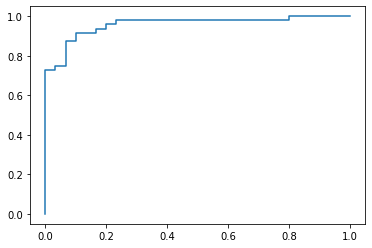

In [66]:
plt.plot(fpr,tpr)
plt.show() 

In [67]:
# This is the AUC
auc = np.trapz(tpr,fpr)
auc

0.9576388888888888

In [102]:
from sklearn.linear_model import LogisticRegressionCV
logreg=LogisticRegressionCV(cv=5, random_state=0, solver='newton-cg').fit(X,Y)
print(logreg.score(X,Y))
print(logreg.score(x_test, y_test))
print(logreg.score(x_train, y_train))

0.8974358974358975
0.9102564102564102
0.8931623931623932


In [103]:
#for confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = metrics.confusion_matrix(y_test, y_p)
print(cm)

[[28  2]
 [ 2 46]]


In [104]:
predictions_X = pd.DataFrame(clf.predict(X))
pred_X_prob = pd.DataFrame(clf.predict_proba(X))
horizontal_stack = pd.concat([X, Y, predictions_X, pred_X_prob], axis=1)
horizontal_stack.to_excel(r"D:\IIT\PhD projects\_dG study\manuscript\rejected-IEEE TCBB_revision\revision\sota_comparison\RF_predictions_on_entire_X.xlsx") 

In [105]:
pred_X_prob

,0,1
0,0.25,0.75
1,0.00,1.00
2,0.00,1.00
3,0.00,1.00
4,0.00,1.00
...,...,...
307,0.00,1.00
308,1.00,0.00
309,1.00,0.00
310,1.00,0.00


In [106]:
###### reusmes RF analysis #################
rf_pred_X_prob = clf.predict_proba(x_test)

In [107]:
rf_pred_X_prob

array([[0.25, 0.75],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [1.  , 0.  ],
       [0.25, 0.75],
       [0.  , 1.  ],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.25, 0.75],
       [0.5 , 0.5 ],
       [0.5 , 0.5 ],
       [0.25, 0.75],
       [0.  , 1.  ],
       [0.5 , 0.5 ],
       [0.25, 0.75],
       [0.25, 0.75],
       [0.  , 1.  ],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.75, 0.25],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.25, 0.75],
       [1.  , 0.  ],
       [0.25, 0.75],
       [0.75, 0.25],
       [0.75, 0.25],
       [0.75, 0.25],
       [0.75, 0.25],
       [0.  , 1.  ],
       [0.5 , 0.5 ],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.25, 0.75],
       [0.  ,

In [108]:
cm1 = metrics.confusion_matrix(y_test, y_p)
print(cm1)

[[28  2]
 [ 2 46]]


In [72]:
# def plot_confusion_matrix(c, title='Confusion matrix', cmap=plt.cm.Blues):
#     plt.imshow(c, interpolation= 'nearest',cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
#     plt.xticks(tick_marks, y_names)
#     plt.yticks(tick_marks, y_names)
#     plt.tight_layout()
#     plt.xlabel('True Label')
#     plt.ylabel('Predicted Label')

In [73]:
# np.set_printoptions(precision=2)
# print(cm1)
# plt.figure()
# plot_confusion_matrix(cm1)

Text(0.5, 0, 'Predicted label')

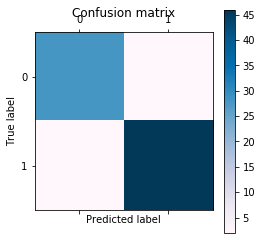

In [109]:
plt.matshow(cm1, cmap='PuBu')
plt.title("Confusion matrix")
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')

[[0.93333333 0.06666667]
 [0.04166667 0.95833333]]


<Figure size 720x720 with 0 Axes>

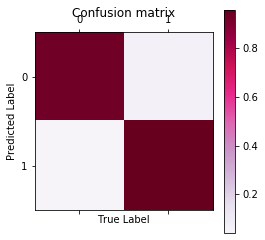

In [110]:
#normalized confusion matrix

plt.figure(figsize=(10,10))

cm2 = cm1.astype('float') / cm1.sum(axis=1)[:, np.newaxis]
print(cm2)
plt.matshow(cm2, cmap='PuRd')
plt.title('Confusion matrix')
plt.colorbar()
plt.xlabel('True Label')
plt.ylabel('Predicted Label')

plt.savefig(r'D:\IIT\PhD projects\_dG study\manuscript\images\normalized_confusion_matrix.png', dpi=600)

In [111]:
#for precision recall curve for whole data
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
print("Precision score:", precision_score(Y, predictions_X))
print("Recall score:", recall_score(Y, predictions_X))
print("F1 score:", f1_score(Y, predictions_X))

Precision score: 0.9834254143646409
Recall score: 0.956989247311828
F1 score: 0.9700272479564033


In [112]:
# #for precision recall curve of test data
# from sklearn.metrics import precision_score
# from sklearn.metrics import recall_score
# from sklearn.metrics import f1_score
# print("Precision score:", precision_score(y_test, predictions_test))
# print("Recall score:", recall_score(y_test, predictions_test))
# print("F1 score:", f1_score(y_test, predictions_test))

In [113]:
predictions_train = clf.predict(x_train)

In [114]:
#for train data
print("Precision score:", precision_score(y_train, predictions_train))
print("Recall score:", recall_score(y_train, predictions_train))
print("F1 score:", f1_score(y_train, predictions_train))

Precision score: 0.9924812030075187
Recall score: 0.9565217391304348
F1 score: 0.974169741697417


0.9440438034188036


Text(0, 0.5, 'Precision')

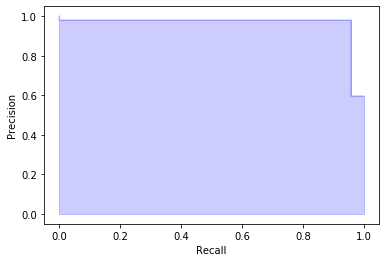

In [115]:
from tqdm import tqdm
from sklearn.metrics import average_precision_score, auc, roc_curve, precision_recall_curve
avg_precision = average_precision_score(y_test, y_p)
print(avg_precision)

precision, recall, _ = precision_recall_curve(Y, predictions_X)
plt.step(recall, precision, color = 'b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')

random forest auc=0.982


NameError: name 'pyplot' is not defined

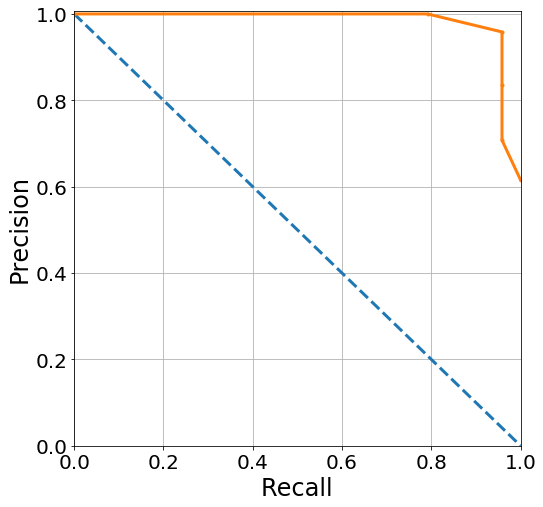

In [117]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from matplotlib import pyplot as plt

clf_precision, clf_recall, _ = precision_recall_curve(y_test, rf_pred_X_prob[:,1])
clf_auc = auc(clf_recall, clf_precision)

# summarize scores
print('random forest auc=%.3f' % (clf_auc))

plt.figure(figsize=(8,8))

# plot the precision-recall curves
no_skill = len(y_p[y_p==1]) / len(y_test)
plt.plot([0, 1], [1,0], linestyle='--', label='No Skill',linewidth=3.0)
#pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(clf_recall, clf_precision, marker='.', label='Classifier', linewidth=3.0)

# axis labels
plt.xlabel('Recall', fontsize=24)
plt.ylabel('Precision', fontsize=24)
plt.xlim(0, 1)
plt.ylim(0, 1.007)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
# show the legend
#pyplot.legend()
# show the plot
plt.show()


plt.savefig(r'D:\IIT\PhD projects\_dG study\manuscript\images\precision-recall.png', dpi=600)

No Skill: ROC AUC=0.500
RF: ROC AUC=0.960


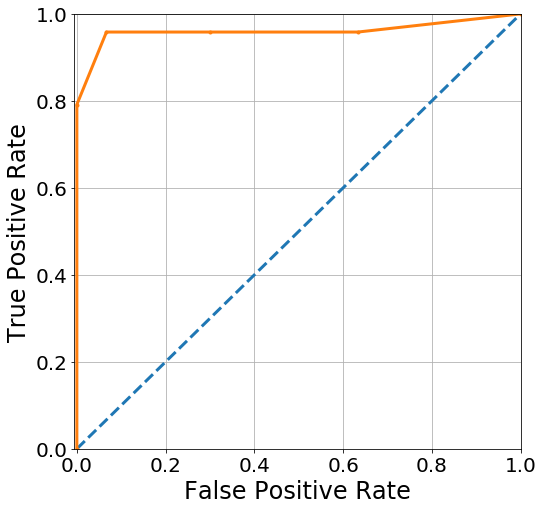

In [120]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

lr_probs = clf.predict_proba(x_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

ns_probs = [0 for _ in range(len(y_test))]

ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('RF: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

plt.figure(figsize=(8,8))


# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', linewidth=3)
plt.plot(lr_fpr, lr_tpr, marker='.', label='RF',linewidth=3)

# axis labels

plt.xlabel('False Positive Rate', fontsize=24)
plt.ylabel('True Positive Rate', fontsize=24)
plt.xlim(-0.006, 1)
plt.ylim(0, 1)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# show the legend
#pyplot.legend()
plt.grid()
# show the plot
plt.show()

In [121]:
X.shape

(312, 35)

0.9458333333333334


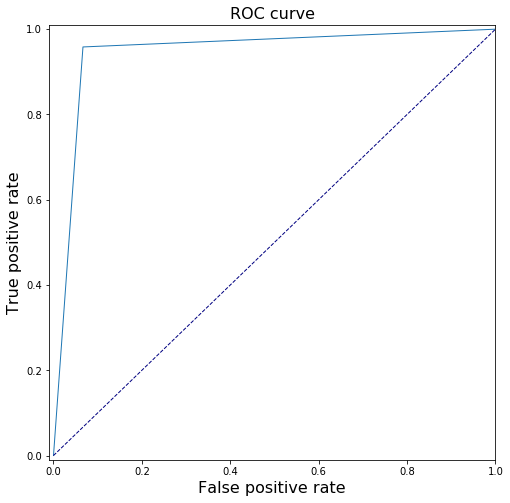

In [122]:
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_p)
roc_auc_rf = auc(fpr_rf, tpr_rf)
print(roc_auc_rf)
plt.figure(figsize=(8,8))
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_rf, tpr_rf, lw=1)


plt.xlabel('False positive rate', fontsize=16)
plt.ylabel('True positive rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.plot([0,1],[0,1], color='navy', lw=1, linestyle='--')
plt.show()

In [123]:
#Naive Bayes
from sklearn.naive_bayes import GaussianNB
AG =[]
for i in range(40):
    model=GaussianNB()
    model.fit(x_train, y_train)
    y_pred= model.predict(x_test)
    AG.append(metrics.accuracy_score(y_test, y_pred))

In [124]:
max(AG) 

0.8589743589743589

In [125]:
#KNN

from sklearn.neighbors import KNeighborsClassifier
K_range = range(1,50)
scores=[]
a=[]
for k in K_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(x_train, y_train)
    y_pred = knn.predict(x_test)
    scores.append(metrics.accuracy_score(y_test,y_pred))
    a.append(k)

In [126]:
print(max(scores))
print(scores.index(max(scores))) 
a[1] 

0.9102564102564102
1


2

In [127]:
#SVM

from sklearn import svm
sv = svm.SVC(kernel='linear', C=1, probability=True)
sv.fit(x_train, y_train)
y_pred = sv.predict(x_test)
print(metrics.accuracy_score(y_test,y_pred))

0.9102564102564102


[0.890625   0.83870968 0.83870968 0.85483871 0.88709677]
0.8619959677419355
[0.9233871 0.932     0.924     0.936     0.92     ]
0.9270774193548388
[[113  13]
 [ 10 176]]


Text(0.5, 0, 'Predicted label')

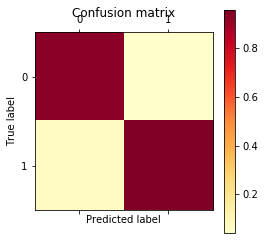

In [128]:
# cross-validation
cv=cross_validate(sv, X, Y, cv=5, return_train_score=True)
print(cv['test_score'])
print(cv['test_score'].mean()) 
print(cv['train_score'])
print(cv['train_score'].mean()) 

Y_all_pred = sv.predict(X)
#confusion matrix
cm = metrics.confusion_matrix(Y, Y_all_pred)
print(cm)
cm2 = cm1/cm1.sum(axis=1)

plt.matshow(cm2, cmap='YlOrRd')
plt.title("Confusion matrix")
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')

whole data
Precision score: 0.9312169312169312
Recall score: 0.946236559139785
F1 score: 0.9386666666666666
test data
Precision score: 0.9183673469387755
Recall score: 0.9375
F1 score: 0.9278350515463918
0.8994309262166404


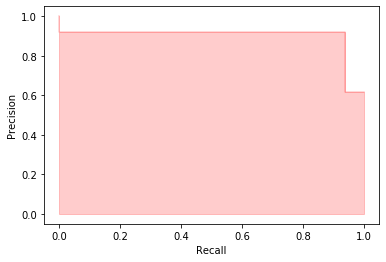

In [129]:
## PR curve
print("whole data")
print("Precision score:", precision_score(Y, Y_all_pred))
print("Recall score:", recall_score(Y, Y_all_pred))
print("F1 score:", f1_score(Y, Y_all_pred))

print("test data")
print("Precision score:", precision_score(y_test, y_pred))
print("Recall score:", recall_score(y_test, y_pred))
print("F1 score:", f1_score(y_test, y_pred))

precision, recall, _ = precision_recall_curve(y_test, y_pred)
plt.step(recall, precision, color = 'r', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='r')

plt.xlabel('Recall')
plt.ylabel('Precision')

avg_precision = average_precision_score(y_test, y_pred)
print(avg_precision)

0.9020833333333333


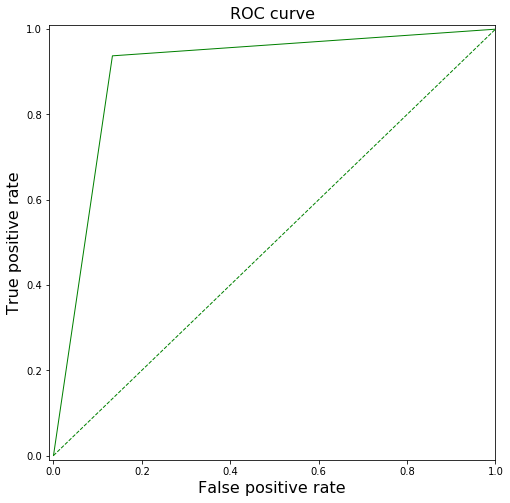

In [130]:
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred)
roc_auc_rf = auc(fpr_rf, tpr_rf)
print(roc_auc_rf)
plt.figure(figsize=(8,8))
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_rf, tpr_rf, lw=1, color='green')


plt.xlabel('False positive rate', fontsize=16)
plt.ylabel('True positive rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.plot([0,1],[0,1], color='green', lw=1, linestyle='--')
plt.show()

In [131]:
import warnings
explainer = shap.KernelExplainer(sv.predict_proba, x_train, link="logit")

# plot the SHAP values for the Setosa output of the first instance
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    shap_values = explainer.shap_values(x_test, n_samples=100)


Using 234 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [132]:
shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], x_test.iloc[0,:], link="logit")

In [133]:
shap.force_plot(explainer.expected_value[0], shap_values[0], x_test, link="logit")

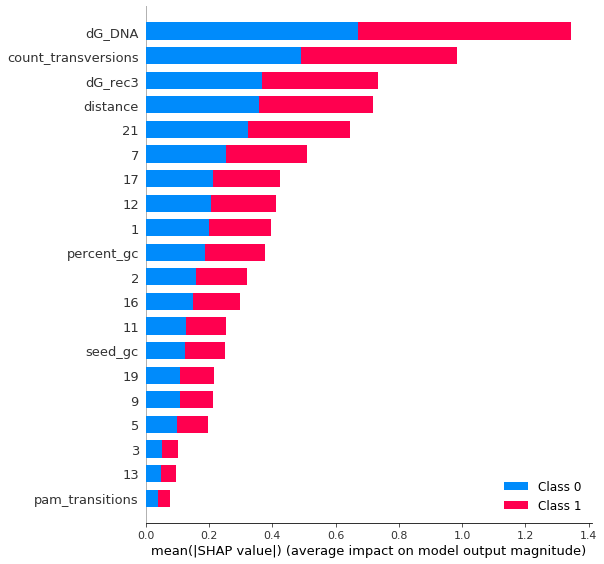

In [134]:
shap.summary_plot(shap_values, X)

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    shap_values= explainer.shap_values(X)
    
shap.summary_plot(shap_values[0], X)

In [ ]:
sv1 = svm.SVC(kernel='rbf')
sv1.fit(x_train, y_train)
y_pred = sv1.predict(x_test)
print(metrics.accuracy_score(y_test,y_pred))

In [ ]:
sv2 = svm.SVC(kernel='poly')
sv2.fit(x_train, y_train)
y_pred = sv2.predict(x_test)
print(metrics.accuracy_score(y_test,y_pred))

In [ ]:
sv3 = svm.SVC(kernel='sigmoid')
sv3.fit(x_train, y_train)
y_pred = sv3.predict(x_test)
print(metrics.accuracy_score(y_test,y_pred))

In [ ]:
#Decision tree

from sklearn.tree import DecisionTreeClassifier
AD=[]
for i in range(40):
    dt = DecisionTreeClassifier(random_state=i)
    dt.fit(x_train,y_train)
    y_pred = dt.predict(x_test)
    AD.append(metrics.accuracy_score(y_test,y_pred))

In [ ]:
max(AD) 

In [ ]:
import shap
shap.initjs()
explainer= shap.TreeExplainer(clf)
shap_values= explainer.shap_values(X)
shap.force_plot(explainer.expected_value[1], shap_values[1])

In [ ]:
shap.summary_plot(shap_values, X)

In [ ]:
def shap_plot(j):
    shap_values_Model = explainer.shap_values(x_test)
    p = shap.force_plot(explainer.expected_value, shap_values_Model[j], x_test.iloc[[j]])
    return(p)

In [ ]:
choosen_instance = x_test.loc[[17]]
shap_values = explainer.shap_values(choosen_instance)
shap.force_plot(explainer.expected_value[1], shap_values[1], choosen_instance)

In [ ]:
choosen_instance = x_test.loc[[10]]
shap_values = explainer.shap_values(choosen_instance)
shap.force_plot(explainer.expected_value[1], shap_values[1], choosen_instance)

In [ ]:
choosen_instance = x_test.loc[[21]]
shap_values = explainer.shap_values(choosen_instance)
shap.force_plot(explainer.expected_value[1], shap_values[1], choosen_instance)

In [ ]:
shap_values= explainer.shap_values(X)
shap.summary_plot(shap_values[0], X)

In [ ]:
shap.waterfall_plot(explainer.expected_value, shap_values[0], feature_names=X.columns.values, max_display=5, show=True)

In [ ]:
x_test.head()

In [ ]:
len(target)

In [ ]:
data=X

In [ ]:
#to calculate frequency of mismatches when y=0
for i in range(len(x)):
    count = x['distance'].value_counts()
count.plot(kind='barh', figsize=(8,8))
plt.ylabel("Distance")
plt.xlabel("Frequency")
plt.title("Considering dataset with y=0")

In [ ]:
#to calculate frequency of mismatches when y=1
for i in range(len(x1)):
    count1 = x1['distance'].value_counts()
count1.plot(kind='barh', figsize=(8,8))
plt.ylabel("Distance")
plt.xlabel("Frequency")
plt.title("Considering dataset with y=1")

In [ ]:
#to calculate frequency of mismatches in X
for i in range(len(X)):
    count2 = X['distance'].value_counts()
count2.plot(kind='barh', figsize=(10,10))
plt.ylabel("Distance")
plt.xlabel("Frequency")
plt.title("Considering entire dataset")

In [ ]:
len(X)

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
xg_reg = xgb.XGBClassifier(objective='reg:logistic', colsample_bytree=0.3, learning_rate=0.1, max_depth=40, aplha=1, gamma = 5, n_estimators=3000)
xg_reg.fit(x_train, y_train)
pred = xg_reg.predict(x_test)
acc = (metrics.accuracy_score(y_test, pred))

print("Accuracy= ", acc)
print("Precision score:", precision_score(y_test, pred))
print("Recall score:", recall_score(y_test, pred))
print("F1 score:", f1_score(y_test, pred))

In [ ]:
xg_reg = xgb.XGBClassifier(objective='reg:logistic', colsample_bytree=0.1, learning_rate=0.1, max_depth=20, aplha=1, gamma = 5, n_estimators=3000)
xg_reg.fit(x_train, y_train, early_stopping_rounds=3, eval_set=[(x_train,y_train)], verbose=False)
pred = xg_reg.predict(x_test)
acc =(metrics.accuracy_score(y_test, pred))
print(acc)
print("Precision score:", precision_score(y_test, pred))
print("Recall score:", recall_score(y_test, pred))
print("F1 score:", f1_score(y_test, pred))

cv=cross_validate(xg_reg, X, Y, cv=5, return_train_score=True)
print(cv['test_score'])
print(cv['test_score'].mean()) 
print(cv['train_score'])
print(cv['train_score'].mean()) 

In [ ]:
Y_pred = xg_reg.predict(X)
#confusion matrix
cm = metrics.confusion_matrix(Y, Y_pred)
print(cm)
cm2 = cm1/cm1.sum(axis=1)

plt.matshow(cm2)
plt.title("Confusion matrix")
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [ ]:
## PR curve
print("whole data")
print("Precision score:", precision_score(Y, Y_pred))
print("Recall score:", recall_score(Y, Y_pred))
print("F1 score:", f1_score(Y, Y_pred))

print("test data")
print("Precision score:", precision_score(y_test, pred))
print("Recall score:", recall_score(y_test, pred))
print("F1 score:", f1_score(y_test, pred))

precision, recall, _ = precision_recall_curve(y_test, pred)
plt.step(recall, precision, color = 'r', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='r')

plt.xlabel('Recall')
plt.ylabel('Precision')

avg_precision = average_precision_score(y_test, pred)
print(avg_precision)

In [ ]:
fpr_rf, tpr_rf, _ = roc_curve(y_test, pred)
roc_auc_rf = auc(fpr_rf, tpr_rf)
print(roc_auc_rf)
plt.figure(figsize=(8,8))
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_rf, tpr_rf, lw=1, color='purple')


plt.xlabel('False positive rate', fontsize=16)
plt.ylabel('True positive rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.plot([0,1],[0,1], color='purple', lw=1, linestyle='--')
plt.show()

In [ ]:
shap.initjs()

# explain the model's predictions using SHAP
explainer = shap.TreeExplainer(xg_reg)
shap_values = explainer.shap_values(X)

# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

In [ ]:
choosen_instance = x_test.loc[[17]]
shap_values = explainer.shap_values(choosen_instance)
shap.force_plot(explainer.expected_value, shap_values, choosen_instance)

In [ ]:
choosen_instance = x_test.loc[[13]]
shap_values = explainer.shap_values(choosen_instance)
shap.force_plot(explainer.expected_value, shap_values, choosen_instance)

In [ ]:
shap.dependence_plot("dG_DNA", shap_values, X)

In [ ]:
shap.dependence_plot("dG_rec3", shap_values, X)

In [ ]:
shap.dependence_plot("distance", shap_values, X)

In [ ]:
shap.summary_plot(shap_values, X)

In [ ]:
shap.summary_plot(shap_values, X, plot_type="bar")